In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os
from torchsummary import summary

In [2]:
!pip install torchsummary

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,filename,category,tv
0,0001-2.wav,healthy,0
1,0002-1.wav,healthy,0
2,0002-2.wav,healthy,0
3,0002-3.wav,healthy,0
4,0002-4.wav,healthy,0


In [5]:
train = df[df['tv']==0]
valid = df[df['tv']==1]

In [6]:
wav, sr = librosa.load('all_data/0001-1.wav', sr=48000)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 48000 and length of the audio is 9.008958333333334 seconds


In [7]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [8]:
def get_melspectrogram_db(file_path, sr=48000, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax, pad_mode='reflect')
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [9]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[...,np.newaxis])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [10]:
class ESC50Model(nn.Module):
  def __init__(self, input_shape, batch_size=16):
    super().__init__()
    self.conv0 = nn.Conv2d(128, 1, kernel_size = 3, stride=1, padding=1)
    self.bn0 = nn.BatchNorm2d(32)
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256, 64)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(64, 2)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

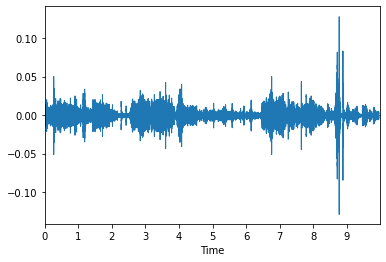

In [11]:
filename = valid[valid['category']=='wheezing'].iloc[0]['filename']
wav, sr = librosa.load('all_data/'+filename, sr=48000)
librosa.display.waveplot(wav, sr)

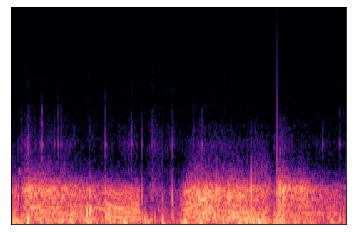

In [12]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('all_data/'+filename, sr=48000)))

In [13]:
train_data = ESC50Data('all_data', train, 'filename', 'category')

/home/nextgen/anaconda3/envs/kbs_breath/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/211 [00:00<?, ?it/s]

In [14]:
valid_data = ESC50Data('all_data', valid, 'filename', 'category')

/home/nextgen/anaconda3/envs/kbs_breath/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/52 [00:00<?, ?it/s]

In [15]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [16]:
for epoch in range(2):
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = np.array(inputs)
        print(inputs.shape)
        # Run your training process
        print(f'Epoch: {i} | Inputs {inputs} | Labels {labels}')

(16, 128, 469, 1)
Epoch: 0 | Inputs [[[[135]
   [156]
   [158]
   ...
   [201]
   [188]
   [147]]

  [[140]
   [141]
   [140]
   ...
   [193]
   [183]
   [155]]

  [[117]
   [109]
   [119]
   ...
   [170]
   [160]
   [138]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[186]
   [201]
   [204]
   ...
   [154]
   [131]
   [146]]

  [[177]
   [195]
   [201]
   ...
   [136]
   [101]
   [127]]

  [[180]
   [175]
   [176]
   ...
   [115]
   [110]
   [ 95]]

  ...

  [[ 39]
   [ 20]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[ 12]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[ 18]
   [  2]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[214]
   [214]
   [201]
   ...
   [161]
   [155]
   [147]]

  [[178]
   [187]
   [189]
   ...
   [142]
   [135]
   [137]]

  [[167]
   [172]
   [168]
   ...
   [116]
   [123]
   [119]]

 

In [17]:
for idx, sample in enumerate(train_loader):
    print(idx, sample[0].size(),
         sample[0].size())

0 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
1 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
2 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
3 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
4 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
5 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
6 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
7 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
8 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
9 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
10 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
11 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
12 torch.Size([16, 128, 469, 1]) torch.Size([16, 128, 469, 1])
13 torch.Size([3, 128, 469, 1]) torch.Size([3, 128, 469, 1])


In [18]:
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [19]:
model = ESC50Model(input_shape=(128, 469, 1), batch_size=16).to(device)

In [20]:
summary(model, (128, 469, 1))

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[2, 128, 469, 1] to have 1 channels, but got 128 channels instead

In [21]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [22]:
loss_fn = nn.BCELoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 60
train_losses = []
valid_losses = []

In [23]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [24]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/home/nextgen/anaconda3/envs/kbs_breath/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/60 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[16, 128, 469, 1] to have 1 channels, but got 128 channels instead